Base : 0.2228

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
import re
from time import time
import gc
pd.options.display.max_columns = 999

import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from sklearn.decomposition import TruncatedSVD

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
        `float64` type to `float32`
        `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Parameters

In [3]:
DATA_PATH = ''
DATA_PATH = 'E:/Kaggle/Avito/'
DATA_IMAGE_PATH = DATA_PATH + 'images//'

In [4]:
seed = 32
VALID = False #Whether or not the notebook should run a validation
n_components_title = 25 #best between 20 and 30
colnames_svdtitle = ['svd_title_'+str(x) for x in range(n_components_title)]
n_components_desc = 40 #best between 35 and 50
colnames_svddesc = ['svd_desc_'+str(x) for x in range(n_components_desc)]

REMOVE_MISSING_DESC = True
ENCODING = True

min_class_encode = 100 #How many items a class must have to be eligible for target encoding
min_class_cat = 31 #How many items a class must have to keep its separate class
STEM = True

## Load data
complete_data is a concatenate of both dataset + some translations

In [5]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')
complete_data = pd.concat([train,test],axis=0,ignore_index=True)

In [6]:
if STEM:
    complete_data_stemmed = pd.read_csv(DATA_PATH+'stemmed_text.csv')
    complete_data = pd.concat([complete_data,complete_data_stemmed.drop('item_id',axis=1)],axis=1)

In [7]:
complete_data.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type,stemmed_description,stemmed_title,stemmed_params
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,b912c3c6a6ad,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.0,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private,кокон для сна малыш пользова меньш месяц цвет сер,кокоб кокон для сна,постельн принадлежностинанна
1,2017-03-26,Мебель и интерьер,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,2dac0150717d,19,Другое,NaN,NaN,Для дома и дачи,3000.0,Самарская область,Стойка для Одежды,39aeb48f0017,Private,стойк для одежд под вешалк с бутик,стойк для одежд,другоенанна
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0,Ростовская область,Philips bluray,91e2f88dd6e3,Private,в хорош состоян домашн кинотеатр с blu ra usb ...,philips blura,виде dvd и blu ra плеерынанна
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,02996f1dd2ea,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0,Татарстан,Автокресло,bf5cccea572d,Company,прод кресл от0 25кг,автокресл,автомобильн креслананна
4,2017-03-16,Автомобили,Волгоград,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,7c90be56d2ab,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private,все вопрос по телефон,ваз 2110 2003,с пробегомваз lad 2110


## Feature engineering

In [8]:
complete_data['missing_param_1'] = complete_data['param_1'].isnull().astype(int)
complete_data['missing_param_2'] = complete_data['param_2'].isnull().astype(int)
complete_data['missing_param_3'] = complete_data['param_3'].isnull().astype(int)
complete_data['missing_desc'] = complete_data['description'].isnull().astype(int)
complete_data['missing_price'] = complete_data['price'].isnull().astype(int)
complete_data['missing_image'] = complete_data['image'].isnull().astype(int)

In [9]:
complete_data['activation_date']=pd.to_datetime(complete_data['activation_date'])
complete_data['activation_weekday']=complete_data['activation_date'].dt.weekday

In [10]:
complete_data['user_counts']=complete_data.groupby(['user_id'])['item_id'].transform('count')
complete_data['user_counts_bin']=pd.qcut(complete_data['user_counts'],5,duplicates='drop',labels=range(4)) #one duplicate. #This feature often appears not useful

In [11]:
common_users = set(train['user_id']).intersection(set(test['user_id']))
temp = train.groupby(['user_id'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_users = set(temp[temp['count_item']>=min_class_cat]['user_id'])

complete_data['user_id'] = np.where(complete_data['user_id'].isin(common_users),
                                    np.where(complete_data['user_id'].isin(big_users),
                                             complete_data['user_id'],'SmallUser'),'NotCommonUser') #This is why an embedding of the user is useful

In [12]:
complete_data['log_price']=np.log(1+complete_data['price'])

In [13]:
complete_data['region_mean_price'] = complete_data.groupby(['region'])['log_price'].transform('mean').fillna(-999)
complete_data['region_category_mean_price'] = complete_data.groupby(['region','category_name'])['log_price'].transform('mean').fillna(-999)
complete_data['region_image_mean_price'] = complete_data.groupby(['region','image_top_1'])['log_price'].transform('mean').fillna(-999)
complete_data['region_image_diff_price'] = complete_data['log_price']-complete_data['region_image_mean_price']

In [14]:
complete_data['city_counts']=complete_data.groupby(['city'])['item_id'].transform('count')
complete_data['city_counts_bin']=pd.qcut(complete_data['city_counts'],5,duplicates='drop',labels=range(5))

In [15]:
common_cities = set(train['city']).intersection(set(test['city']))
temp = train.groupby(['city'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_cities = set(temp[temp['count_item']>=min_class_cat]['city'])

complete_data['city'] = np.where(complete_data['city'].isin(common_cities),
                                  np.where(complete_data['city'].isin(big_cities),
                                           complete_data['city'],'SmallCity'),'NotCommonCity')

In [16]:
complete_data['city_mean_price'] = complete_data.groupby(['city'])['log_price'].transform('mean')
complete_data['city_category_mean_price'] = complete_data.groupby(['city','category_name'])['log_price'].transform('mean')
complete_data['city_image_mean_price'] = complete_data.groupby(['city','image_top_1'])['log_price'].transform('mean')
complete_data['city_image_diff_price'] = complete_data['log_price']-complete_data['city_image_mean_price']

In [17]:
#If useful, add additional prices information

In [18]:
complete_data['price'].fillna(-999,inplace=True)
complete_data['log_price'].fillna(-999,inplace=True)
complete_data['price_10']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//10).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_100']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//100).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_1000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//1000).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_10000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//10000).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['price_100000']=np.where(complete_data['price']>=0, (complete_data['price'].astype(int)//100000).astype(str).apply(lambda x: x[-1]),-999).astype(int)
complete_data['start_100']=np.where(complete_data['price']>=100, np.where(complete_data['price'].astype(int)-complete_data['price'].astype(int)//100*100 < 50, 1 , 0) ,-999)
complete_data['start_1000']=np.where(complete_data['price']>=1000, np.where(complete_data['price'].astype(int)-complete_data['price'].astype(int)//1000*1000 < 500, 1 , 0) ,-999)
complete_data['start_10000']=np.where(complete_data['price']>=10000, np.where(complete_data['price'].astype(int)-complete_data['price'].astype(int)//10000*10000 < 5000, 1 , 0) ,-999)
complete_data['start_100000']=np.where(complete_data['price']>=100000, np.where(complete_data['price'].astype(int)-complete_data['price'].astype(int)//100000*100000 < 50000, 1 , 0) ,-999)
complete_data['number_of_0']=np.where(complete_data['price']>=100, complete_data['price'].astype(int).astype(str).apply(lambda x: x.count('0')),-999)
complete_data['length_price']=np.where(complete_data['price']>=100, complete_data['price'].astype(int).astype(str).apply(len),-999)
complete_data['diff_of_0']=np.where(complete_data['price']>=100,complete_data['length_price']-complete_data['number_of_0'],-999)

In [19]:
complete_data['log_item_seq']=np.log(1+complete_data['item_seq_number'])

In [20]:
complete_data['image_top_1'].fillna(-999,inplace=True)
train['image_top_1'].fillna(-999,inplace=True)
test['image_top_1'].fillna(-999,inplace=True)
new_image_top = set(test['image_top_1'])-set(train['image_top_1'])
complete_data['image_top_1']=np.where(complete_data['image_top_1'].isin(new_image_top),
                                      -999,complete_data['image_top_1']) #should actually select the closest image class

In [21]:
heatmatrix = pd.crosstab(train['image_top_1'],train['category_name'])
rows = heatmatrix.index
columns = heatmatrix.columns
heatmatrix = heatmatrix.values / np.sum(heatmatrix.values,axis=1,keepdims=True) #Normalize
heatmatrix = pd.DataFrame(heatmatrix,index=rows,columns=columns)
values = []
for image_top_1 in heatmatrix.index:
    for category in heatmatrix.columns:
        values.append([image_top_1,category,heatmatrix.loc[image_top_1,category]])
matrix_long = pd.DataFrame(values,columns=['image_top_1','category_name','heatmatrix_value'])
complete_data = complete_data.merge(matrix_long,how='left',on=['image_top_1','category_name'])
complete_data['heatmatrix_value'].fillna(-999,inplace=True)
#Number of classes in category
class_counts = (heatmatrix>0).sum(axis=0)
class_max = heatmatrix.max(axis=0)
class_mean = heatmatrix.mean(axis=0)
complete_data['class_category_counts'] = complete_data['category_name'].map(class_counts)
complete_data['class_category_max'] = complete_data['category_name'].map(class_max)
complete_data['class_category_mean'] = complete_data['category_name'].map(class_mean)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [22]:
uppercase_regex = re.compile(r'[A-ZА-Я]')
symbols_regex = re.compile(r'[^a-zA-ZА-Я0-9а-я]')
digits_regex = re.compile(r'[0-9]')

In [23]:
complete_data['title_number_uppercase'] = complete_data['title'].str.count(uppercase_regex)
complete_data['title_number_symbols'] = complete_data['title'].str.count(symbols_regex)
complete_data['title_number_digits'] = complete_data['title'].str.count(digits_regex)
complete_data['title_len_chars'] = complete_data['title'].apply(lambda x: len(str(x)))
complete_data['title_len_words'] = complete_data['title'].str.split().apply(lambda x: len(str(x)))
complete_data['title_unique'] = complete_data['title'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_title'] = complete_data['title_unique']/complete_data['title_len_words']

In [24]:
#Do that before filling missings
complete_data['desc_number_uppercase'] = complete_data['description'].str.count(uppercase_regex)
complete_data['desc_number_symbols'] = complete_data['description'].str.count(symbols_regex)
complete_data['desc_number_digits'] = complete_data['description'].str.count(digits_regex) #should do similar stuff for param
complete_data['desc_len_char']=complete_data['description'].apply(lambda x: len(str(x)))
complete_data['desc_len_words']=complete_data['description'].str.split().apply(lambda x: len(str(x)))
complete_data['desc_unique'] = complete_data['description'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_desc'] = complete_data['desc_unique']/complete_data['desc_len_words']

In [25]:
complete_data['desc_number_uppercase'].fillna(-999,inplace=True)
complete_data['desc_number_symbols'].fillna(-999,inplace=True)
complete_data['desc_number_digits'].fillna(-999,inplace=True)
complete_data['desc_len_char'].fillna(-999,inplace=True)
complete_data['desc_len_words'].fillna(-999,inplace=True)
complete_data['desc_unique'].fillna(-999,inplace=True)
complete_data['share_unique_desc'].fillna(-999,inplace=True)

In [26]:
test_title = set(complete_data[complete_data['deal_probability'].isna()]['title'])
train_title = set(complete_data[complete_data['deal_probability'].notnull()]['title'])
title_to_include = test_title.intersection(train_title)
complete_data['title_clean']=np.where(complete_data['title'].isin(title_to_include),complete_data['title'],'Other')

In [27]:
complete_data['param_1'] = complete_data['param_1'].astype(str)
complete_data['param_2'] = complete_data['param_2'].astype(str)
complete_data['param_3'] = complete_data['param_3'].astype(str)
complete_data['params'] = complete_data['param_1']+complete_data['param_2']+complete_data['param_3']
#Need to clean this variable

In [28]:
test_params = set(complete_data[complete_data['deal_probability'].isna()]['params'])
train_params = set(complete_data[complete_data['deal_probability'].notnull()]['params'])
params_to_include = test_params.intersection(train_params)
complete_data['params_clean']=np.where(complete_data['params'].isin(params_to_include),complete_data['params'],'Other')

In [29]:
#Can also add loop to do something else than mean encoding
#Need to redo it inside the cross validation
if ENCODING:
    vars_target_encode = ['region', 'user_type', 'category_name', 'parent_category_name','image_top_1','city']#,'user_id']
    global_average = train['deal_probability'].mean()

    for var in vars_target_encode:
        common = set(train[var]).intersection(set(test[var]))
        temp = train.groupby([var],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
        big = set(temp[temp['count_item']>=min_class_encode][var])

        #Encode using running sum
        cumsum = complete_data.groupby([var])['deal_probability'].cumsum()-complete_data['deal_probability']
        cumcnt = complete_data.groupby([var])['deal_probability'].cumcount()
        complete_data[var+'_encoding']=cumsum/cumcnt
        complete_data[var+'_encoding'].fillna(global_average,inplace=True)
        complete_data[var+'_encoding'] = np.where(complete_data[var].isin(common), #Dont encode missing in test set, dont encode too few items in class:
                                          np.where(complete_data[var].isin(big),
                                                   complete_data[var+'_encoding'],global_average),global_average)

In [30]:
if STEM:
    complete_data['description']=complete_data['stemmed_description']
    complete_data['title']=complete_data['stemmed_title']
    complete_data['params']=complete_data['stemmed_params']
    del complete_data['stemmed_description']
    del complete_data['stemmed_title']
    del complete_data['stemmed_params']

In [31]:
texts = ['description','title','params']
for col in texts:
    complete_data[col]=complete_data[col].astype(str).fillna('thisismissing').str.lower()

In [32]:
#Make sparse TFIDF matrixes here (or count)
english_stopwords = set(stopwords.words('english'))
russian_stopwords = set(stopwords.words('russian'))
russian_stopwords = russian_stopwords.union(english_stopwords)
tfidf_desc = TfidfVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             max_features=50000,
                             ngram_range=(1,2),dtype=np.float32,norm='l2',smooth_idf=False,sublinear_tf=True,min_df=2)
X_desc = tfidf_desc.fit_transform(complete_data['description'])
print(X_desc.shape)

(2011862, 50000)


In [33]:
wordVectTitle = CountVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             ngram_range=(1,2),dtype=np.float32,min_df=2,
                             max_features=50000)
title_sparse = wordVectTitle.fit_transform(complete_data['title'])

In [34]:
wordVectParams = CountVectorizer(lowercase=True,analyzer='word',
                             stop_words=russian_stopwords,token_pattern=r'\w+',
                             ngram_range=(1,3),dtype=np.float32,min_df=2,max_features=25000)
params_sparse = wordVectParams.fit_transform(complete_data['params'])

## Make variable lists

In [35]:
#Standard variables
categoricals = ['region','city','activation_weekday','user_type','user_id','parent_category_name','category_name','image_top_1',
               'param_1','param_2','param_3','params_clean','title_clean'] 
numericals = ['log_price','log_item_seq']

#New variables
categoricals += ['missing_param_1','missing_param_2','missing_param_3','missing_desc','missing_price','missing_image']
categoricals += ['user_counts_bin','city_counts_bin']
numericals += ['user_counts','city_counts']
numericals += ['region_mean_price','region_category_mean_price','region_image_mean_price','region_image_diff_price']
numericals += ['city_mean_price','city_category_mean_price','city_image_mean_price','city_image_diff_price']
numericals += ['price_10','price_100','price_1000','price_10000','price_100000']
#,'start_100','start_1000','start_10000','start_100000','number_of_0','length_price','diff_of_0']
numericals += ['heatmatrix_value','class_category_counts','class_category_max','class_category_mean']
numericals += ['title_number_uppercase', 'title_number_symbols','title_number_digits','title_len_chars','title_len_words','title_unique','share_unique_title']
numericals += ['desc_number_uppercase', 'desc_number_symbols','desc_number_digits','desc_len_char','desc_len_words','desc_unique','share_unique_desc']
#numericals += [x+'_encoding' for x in vars_target_encode]

In [36]:
#Sanity check
complete_data.isnull().sum()

activation_date                       0
category_name                         0
city                                  0
deal_probability                 508438
description                           0
image                            155197
image_top_1                           0
item_id                               0
item_seq_number                       0
param_1                               0
param_2                               0
param_3                               0
parent_category_name                  0
price                                 0
region                                0
title                                 0
user_id                               0
user_type                             0
missing_param_1                       0
missing_param_2                       0
missing_param_3                       0
missing_desc                          0
missing_price                         0
missing_image                         0
activation_weekday                    0


## Split and make matrixes

In [37]:
le = LabelEncoder()
for col in categoricals:
    complete_data[col] = le.fit_transform(complete_data[col].astype(str))

In [38]:
complete_data = downcast_dtypes(complete_data)

In [39]:
train = complete_data[complete_data['deal_probability'].notnull()].copy()
test = complete_data[complete_data['deal_probability'].isna()].copy()

In [40]:
features = categoricals + numericals

X = hstack([csr_matrix(train[features].values.astype('float32')),
            X_desc[:len(train)],
            title_sparse[:len(train)],
            params_sparse[:len(train)]],format='csr')

X_test = hstack([csr_matrix(test[features].values.astype('float32')),
            X_desc[len(train):],
            title_sparse[len(train):],
            params_sparse[len(train):]],format='csr')

In [41]:
y = train['deal_probability'].values

### Model

In [42]:
lgb_params = {'learning_rate':0.019,
              'task':'train',
              'boosting_type':'gbdt',
              'metric':'rmse',
              'objective':'regression',
              'num_leaves':250,
              #'max_depth':12,
              'feature_fraction': 0.50,
              'bagging_fraction': 0.70,
              'verbose':0,
              'n_estimators':10000,
              'random_state':seed,
              'num_threads':4 #Put to 4 if you are leaving computer
              }

if not VALID:
    lgb_params['n_estimators']=2600

## Validation Scheme

In [43]:
#kf = KFold(5,shuffle=True,random_state=seed)
kf = ShuffleSplit(n_splits=1,test_size=0.1)

In [44]:
feature_names=features + ['desc_'+ x for x in tfidf_desc.get_feature_names()] + ['title_' + x for x in wordVectTitle.get_feature_names()]+['params'+x for x in  wordVectParams.get_feature_names()]
print(len(feature_names))

104294


In [45]:
feature_importances_split = []
feature_importances_gain = []
if VALID:
    i=0
    rmse=[]
    n_trees =[]
    for train_idx, test_idx in kf.split(X,y):
        start = time()
        
        lgtrain = lgb.Dataset(X[train_idx], y[train_idx],
                    feature_name=feature_names,
                    categorical_feature = categoricals)
        lgvalid = lgb.Dataset(X[test_idx], y[test_idx],
                    feature_name=feature_names,
                    categorical_feature = categoricals)
        
        lgb_model = lgb.train(lgb_params,lgtrain,early_stopping_rounds=75,verbose_eval=50,num_boost_round=lgb_params['n_estimators'],
                      valid_sets=[lgtrain, lgvalid],
                      valid_names=['train','valid'],
                      feature_name=feature_names,
                      categorical_feature=categoricals)

        rmse.append(mean_squared_error(y[test_idx],lgb_model.predict(X[test_idx]).clip(0.0,1.0))**0.5)
        
        n_trees.append(lgb_model.best_iteration)
        feature_importances_split.append(lgb_model.feature_importance(importance_type='split'))
        feature_importances_gain.append(lgb_model.feature_importance(importance_type='gain'))
        
        print('Fold',str(i),'RMSE is',rmse[i])
        print(lgb_model.best_iteration)
        i+=1
        print((time()-start)//60,'Minutes')
    avg_rmse = sum(rmse)/len(rmse)
    avg_trees = sum(n_trees)//len(n_trees)
    print('Average RMSE',avg_rmse,'Average Trees',avg_trees)
else:
        start = time()
        lgtrain = lgb.Dataset(X, y,
                    feature_name=feature_names,
                    categorical_feature = categoricals)
        
        lgb_model = lgb.train(lgb_params,lgtrain,verbose_eval=50,num_boost_round=lgb_params['n_estimators'],
                      feature_name=feature_names,
                      categorical_feature=categoricals)
        
        feature_importances_split.append(lgb_model.feature_importance(importance_type='split'))
        feature_importances_gain.append(lgb_model.feature_importance(importance_type='gain'))
        print((time()-start)//60,'Minutes')

E:\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


93.0 Minutes


## Predictions

In [46]:
predictions = lgb_model.predict(X_test)

In [47]:
if VALID:
    avg_rmse = sum(rmse)/len(rmse)

In [48]:
test['deal_probability']=predictions.clip(0.0,1.0)
if VALID:
    test[['item_id','deal_probability']].to_csv(DATA_PATH+f'{avg_rmse:.4f}_'+'Predictions_LGB.csv',index=False)
else:
    test[['item_id','deal_probability']].to_csv(DATA_PATH+'Predictions_LGB.csv',index=False)

In [49]:
feature_importances_split = np.stack(feature_importances_split).mean(axis=0)
feature_importances_gain = np.stack(feature_importances_gain).mean(axis=0)
importances = pd.DataFrame({'Name':feature_names,
                  'Gain':list(feature_importances_gain),
                 'Split':list(feature_importances_split)})

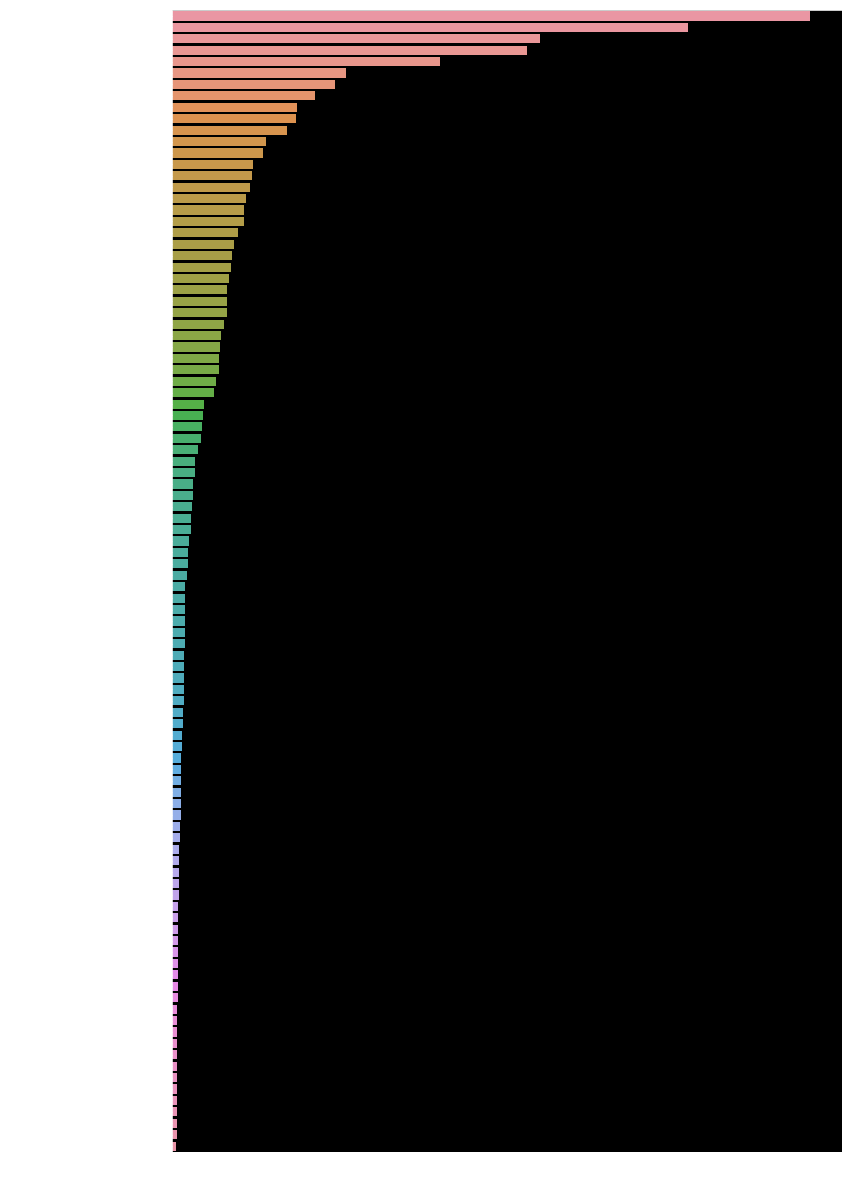

In [50]:
feature_sort = 'Split'
importances = importances.sort_values(feature_sort,ascending=False)
plt.figure(figsize=(12,21))
sns.barplot(x=feature_sort, y='Name',data=importances[:100])
plt.show()

In [53]:
importances[200:300]

,Gain,Name,Split
9074,202.172069,desc_бесплатн,169.0
42665,93.143971,desc_стекл,168.0
17404,107.490148,desc_зарядк,167.0
48229,179.740513,desc_час,164.0
63,95.891526,desc_0,164.0
19550,101.262729,desc_качествен,161.0
8940,92.199422,desc_бел,161.0
7759,148.255382,desc_автокресл,161.0
18359,92.859919,desc_имеет,161.0
39067,117.377223,desc_ручк,160.0
